# Advancing Commonsense Reasoning: Leveraging ConceptNet with Large Language Models for Enhanced Knowledge Representation and Question Answering

By: MEZNA AL-RASHDI

# Install Required Libraries


In [ ]:
# Install NLP and network analysis libraries
!pip install -q spacy nltk networkx matplotlib pandas transformers

# For using Gemini API later (Gemini 2.0)
!pip install -q google-generativeai


#Import Modules

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import spacy

# Optional: Download NLP resources
nltk.download('punkt')
nltk.download('wordnet')

# For Gemini (later)
import google.generativeai as genai


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Load the Files

In [ ]:
# Load concepts
concepts_df = pd.read_csv('/content/concepts_en.csv', delimiter=';', encoding='ISO-8859-1')
concepts_df = concepts_df[['id', 'text']]
concepts_df.columns = ['concept_id', 'concept_text']

# Load relations
relations_df = pd.read_csv('/content/relations.csv', delimiter=',', encoding='ISO-8859-1')
relations_df = relations_df[['id', 'name']]
relations_df.columns = ['relation_id', 'relation_name']

# Load the graph (edges)
graph_df = pd.read_csv('/content/concept_graph.csv', delimiter=';', encoding='ISO-8859-1')
graph_df.columns = ['concept1_id', 'concept2_id', 'relation_id']


<ipython-input-3-01bb1dbf15f6>:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  concepts_df = pd.read_csv('/content/concepts_en.csv', delimiter=';', encoding='ISO-8859-1')


In [ ]:
# Define banned words
banned_words = {"fuck", "shit", "bitch", "ass", "rape", "step dog shit", "to"}  # extend as needed

# Filtered version of concepts
filtered_concepts_df = concepts_df[
    ~concepts_df["concept_text"].str.lower().isin(banned_words)
]

# Show clean sample of concepts
print("Sample of Concepts Dataset:")
display(filtered_concepts_df.head())

# Show rest as-is
print("Sample of Relations Dataset:")
display(relations_df.head())

print("Sample of Concept Graph Dataset:")
display(graph_df.head())


Sample of Concepts Dataset:


concept_id concept_text
0         5.0    something
2         7.0          man
4         9.0       person
6        11.0         type
7        12.0  locker room

Sample of Relations Dataset:


relation_id     relation_name
0            1  HasFirstSubevent
1            2   HasLastSubevent
2            3   HasPrerequisite
3            4            MadeOf
4            5               IsA

Sample of Concept Graph Dataset:


concept1_id  concept2_id  relation_id
0            5            6            6
1            7            8            7
2           12            8            7
3           13           14            7
4           15            8            7

In [ ]:
# Show sample of concepts
print("Sample of Concepts Dataset:")
display(concepts_df.head())

# Show sample of relations
print("Sample of Relations Dataset:")
display(relations_df.head())

# Show sample of edges
print("Sample of Concept Graph Dataset:")
display(graph_df.head())


Sample of Concepts Dataset:


concept_id concept_text
0         5.0    something
1         6.0           to
2         7.0          man
3         8.0         fuck
4         9.0       person

Sample of Relations Dataset:


relation_id     relation_name
0            1  HasFirstSubevent
1            2   HasLastSubevent
2            3   HasPrerequisite
3            4            MadeOf
4            5               IsA

Sample of Concept Graph Dataset:


concept1_id  concept2_id  relation_id
0            5            6            6
1            7            8            7
2           12            8            7
3           13           14            7
4           15            8            7

#Merge the Datasets to Create Human-Readable Triples
We'll combine:
- graph_df: contains connections between concepts by ID

- concepts_df: to get concept names from IDs

- relations_df: to get relation names from IDs

In [ ]:
# Define banned words (extend as needed)
banned_words = ["fuck", "shit", "bitch", "ass", "rape", "burn down", "neighbour wife"]

# Create a regex pattern to match any banned word (case insensitive)
pattern = '|'.join(banned_words)

# Filter out any rows where concept1 or concept2 contains a banned word
triples_df_filtered = triples_df[
    ~triples_df["concept1"].str.lower().str.contains(pattern, regex=True) &
    ~triples_df["concept2"].str.lower().str.contains(pattern, regex=True)
]

# Display the first 10 clean triples
triples_df_filtered.head(10)


concept1 relation_name            concept2
0          something    AtLocation                  to
6       train window    AtLocation               train
7          crossroad    AtLocation                town
8        poor person          HasA    little education
9            armoire    AtLocation   neighbour bedroom
10             wagon    AtLocation                tree
11  idiotic coworker    AtLocation                work
12  write term paper        Causes          turn grade
13           armoire    AtLocation               beach
14  professor prefer   HasSubevent  like better others

In [ ]:
# Merge concept1_id with its text label
graph_merged = graph_df.merge(concepts_df, left_on='concept1_id', right_on='concept_id', how='left')
graph_merged = graph_merged.rename(columns={'concept_text': 'concept1'})
graph_merged = graph_merged.drop(columns=['concept_id'])

# Merge concept2_id with its text label
graph_merged = graph_merged.merge(concepts_df, left_on='concept2_id', right_on='concept_id', how='left')
graph_merged = graph_merged.rename(columns={'concept_text': 'concept2'})
graph_merged = graph_merged.drop(columns=['concept_id'])

# Merge relation_id with its relation name
graph_merged = graph_merged.merge(relations_df, on='relation_id', how='left')

# Select only human-readable triples
triples_df = graph_merged[['concept1', 'relation_name', 'concept2']]
triples_df = triples_df.dropna()  # remove any rows with missing values
triples_df.head(10)


concept1 relation_name             concept2
0     something    AtLocation                   to
1           man       UsedFor                 fuck
2   locker room       UsedFor                 fuck
3  strike match       UsedFor     burn down church
4     townhouse       UsedFor                 fuck
5      backyard       UsedFor  fuck neighbour wife
6  train window    AtLocation                train
7     crossroad    AtLocation                 town
8   poor person          HasA     little education
9       armoire    AtLocation    neighbour bedroom

These are extracted raw from ConceptNet ‚Äî which is crowdsourced and not fully curated, so it contains offensive, biased, or inappropriate data.

Observations
üî¥
1. Inappropriate Entries

Some of these triples contain:

- Explicit or vulgar language

- Violent associations (e.g. "burn down church")

- Social bias (e.g. poor person ‚Üí little education)

These can:

- Harm the quality of reasoning

- Introduce bias or toxicity in LLM responses

- Mislead pattern detection or rule generation

#Build the Concept Graph with NetworkX
We‚Äôll treat the triples as directed edges in a graph:

In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges from filtered triples
for _, row in triples_df.iterrows():
    concept1 = row['concept1']
    relation = row['relation_name']
    concept2 = row['concept2']

    # Add edge with relation as the label
    G.add_edge(concept1, concept2, relation=relation)


#Check Basic Info About the Graph

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Preview some edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} --[{data['relation']}]--> {v}")


Number of nodes: 279476
Number of edges: 478853
something --[AtLocation]--> to
something --[AtLocation]--> bottom drawer
something --[AtLocation]--> bank
something --[AtLocation]--> movies
something --[AtLocation]--> marketplace
something --[AtLocation]--> store
something --[AtLocation]--> bowl alley
something --[CapableOf]--> rest
something --[AtLocation]--> right angle
something --[AtLocation]--> standstill


#Visualize a Small Subgraph

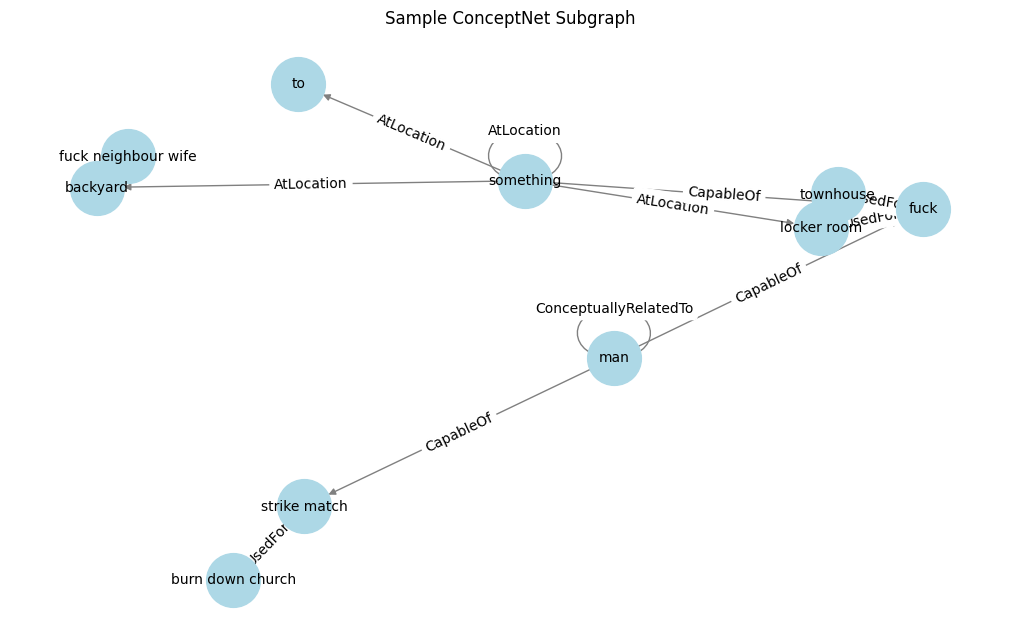

In [ ]:
import matplotlib.pyplot as plt
#Visualize a Small Subgraph
# Extract a subgraph of 10 nodes (for visualization)
small_subgraph = G.subgraph(list(G.nodes)[:10])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(small_subgraph)
nx.draw(small_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=10)
nx.draw_networkx_edge_labels(small_subgraph, pos, edge_labels={(u, v): d['relation'] for u, v, d in small_subgraph.edges(data=True)})
plt.title("Sample ConceptNet Subgraph")
plt.show()


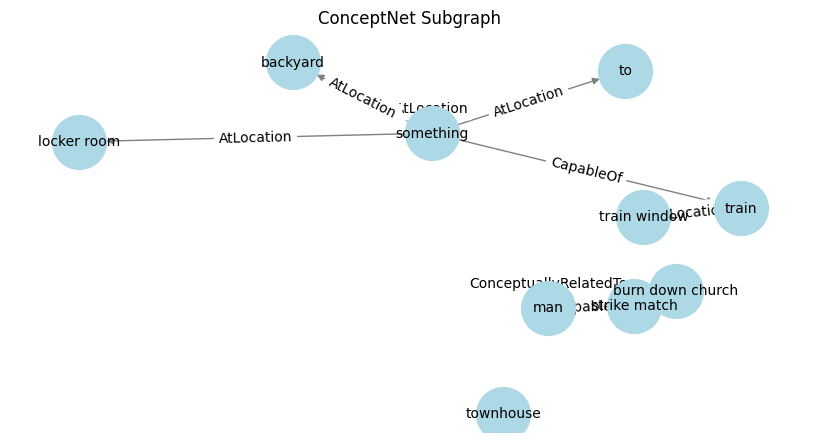

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define a list of banned words
banned_words = {"fuck", "shit", "bitch", "ass", "rape"}  # add more as needed

# Filter nodes that do not contain banned words
filtered_nodes = [
    node for node in list(G.nodes)
    if all(bad_word not in node.lower() for bad_word in banned_words)
]

# Take a subgraph of the first 10 *clean* nodes
safe_nodes = filtered_nodes[:10]
clean_subgraph = G.subgraph(safe_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(clean_subgraph)
nx.draw(clean_subgraph, pos, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=1500, font_size=10)
nx.draw_networkx_edge_labels(
    clean_subgraph, pos,
    edge_labels={(u, v): d['relation'] for u, v, d in clean_subgraph.edges(data=True)}
)
plt.title("ConceptNet Subgraph")
plt.show()


# Ask Gemini to Suggest Rules

In [ ]:
!pip install -q --upgrade google-generativeai
import google.generativeai as genai
from google.colab import userdata

# 3. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

# 2. Select a few example triples to provide context
sample_triples = triples_df.head(10)

# 3. Create prompt for Gemini
triple_list = "\n".join([f"{row['concept1']} - {row['relation_name']} - {row['concept2']}"
                         for _, row in sample_triples.iterrows()])

prompt = (
    "Here are some commonsense knowledge triples from ConceptNet:\n\n"
    f"{triple_list}\n\n"
    "Based on these, can you suggest possible two-hop inference rules or abstract patterns "
    "such as 'If A UsedFor B and B CapableOf C, then A CapableOf C'? "
    "Please give 3‚Äì5 logically sound and semantically plausible rules."
)

# 4. Get Gemini's suggestions
response = model.generate_content(prompt)
print("üîç Suggested Logical Rules:\n")
print(response.text)


üîç Suggested Logical Rules:

Okay, based on the provided ConceptNet examples, here are some potential two-hop inference rules:

1.  **Location Chain:**

    *   **Rule:** If A `AtLocation` B and B `AtLocation` C, then A `AtLocation` C.
    *   **Justification:**  This captures the transitivity of location.  If something is *at* a place, and that place is *at* another place, then the original thing is also, indirectly, *at* that other place. This is a very fundamental spatial reasoning principle.
    *   **Example (Hypothetical):**  "Book `AtLocation` Shelf", "Shelf `AtLocation` Library"  => "Book `AtLocation` Library".

2.  **Purpose Propagation (with risk):**

    *   **Rule:** If A `UsedFor` B and B `CapableOf` C, then A `CapableOf` C. (Or, more cautiously, A `Causes` C).
    *   **Justification:**  If something is used *for* a purpose, and *that* purpose enables something else to happen, then the original thing *can* be indirectly considered capable of enabling that final result. 

Discover Common Reasoning Patterns (2-hop & 3-hop)
We'll search paths like:

Pattern A: A --[IsA]--> B --[UsedFor]--> C

Pattern B: A --[CapableOf]--> B --[Causes]--> C

Pattern C: A --[AtLocation]--> B --[UsedFor]--> C

**Extract 2-Hop Paths:**

In [ ]:
#Extract 2-Hop Paths
from collections import defaultdict

# Dictionary to hold pattern matches
two_hop_patterns = defaultdict(list)

# Loop over all nodes
for node in G.nodes:
    # Get neighbors of node (step 1)
    for neighbor1 in G.successors(node):
        rel1 = G[node][neighbor1]['relation']

        # Step 2: Get neighbors of neighbor1
        for neighbor2 in G.successors(neighbor1):
            rel2 = G[neighbor1][neighbor2]['relation']

            # Save the 2-hop pattern
            pattern = f"{rel1} ‚Üí {rel2}"
            two_hop_patterns[pattern].append((node, neighbor1, neighbor2))


**Show Most Common Patterns**

In [ ]:
# Show top 10 discovered 2-hop patterns
sorted_patterns = sorted(two_hop_patterns.items(), key=lambda x: len(x[1]), reverse=True)
for pattern, matches in sorted_patterns[:10]:
    print(f"\nPattern: {pattern} ‚Äî {len(matches)} matches")
    for a, b, c in matches[:3]:  # show 3 examples
        print(f"  {a} ‚Üí {b} ‚Üí {c}")



Pattern: IsA ‚Üí CapableOf ‚Äî 2968941 matches
  man ‚Üí change tire ‚Üí give hernia
  man ‚Üí change tire ‚Üí messy work
  man ‚Üí mammal ‚Üí breathe air

Pattern: IsA ‚Üí Desires ‚Äî 2057121 matches
  man ‚Üí mammal ‚Üí pain hunger
  man ‚Üí sex ‚Üí person
  man ‚Üí sex ‚Üí creativity

Pattern: IsA ‚Üí IsA ‚Äî 1134800 matches
  man ‚Üí play baseball ‚Üí play
  man ‚Üí change tire ‚Üí hard work
  man ‚Üí change tire ‚Üí dirty job

Pattern: IsA ‚Üí AtLocation ‚Äî 1088850 matches
  man ‚Üí play baseball ‚Üí athetic field
  man ‚Üí mammal ‚Üí least somewhat furry
  man ‚Üí mammal ‚Üí warm blood

Pattern: AtLocation ‚Üí IsA ‚Äî 953156 matches
  something ‚Üí to ‚Üí pro gun mean like gun
  something ‚Üí to ‚Üí frame mean set up
  something ‚Üí to ‚Üí immortal mean never die

Pattern: IsA ‚Üí HasProperty ‚Äî 885447 matches
  man ‚Üí heterosexual ‚Üí stupid
  man ‚Üí heterosexual ‚Üí fish
  man ‚Üí play saxophone ‚Üí satisfy

Pattern: AtLocation ‚Üí CapableOf ‚Äî 818150 matches
  something 

‚ö†Ô∏è But Also...

üëÄ Some patterns still contain noisy/weird examples:

something ‚Üí to ‚Üí immortal mean never die

So this reminds us:

- ConceptNet is crowdsourced, and not every path is high quality.

- Next, we need to score and filter the most meaningful chains.

In [ ]:
# Count and display all unique 2-hop patterns with their match counts
sorted_patterns = sorted(two_hop_patterns.items(), key=lambda x: len(x[1]), reverse=True)

print(f"Total unique 2-hop patterns found: {len(sorted_patterns)}\n")

for idx, (pattern, matches) in enumerate(sorted_patterns, 1):
    print(f"{idx}. Pattern: {pattern} ‚Äî {len(matches)} matches")


Total unique 2-hop patterns found: 674

1. Pattern: IsA ‚Üí CapableOf ‚Äî 2968941 matches
2. Pattern: IsA ‚Üí Desires ‚Äî 2057121 matches
3. Pattern: IsA ‚Üí IsA ‚Äî 1134800 matches
4. Pattern: IsA ‚Üí AtLocation ‚Äî 1088850 matches
5. Pattern: AtLocation ‚Üí IsA ‚Äî 953156 matches
6. Pattern: IsA ‚Üí HasProperty ‚Äî 885447 matches
7. Pattern: AtLocation ‚Üí CapableOf ‚Äî 818150 matches
8. Pattern: HasA ‚Üí CapableOf ‚Äî 809823 matches
9. Pattern: ConceptuallyRelatedTo ‚Üí CapableOf ‚Äî 697968 matches
10. Pattern: AtLocation ‚Üí HasProperty ‚Äî 664696 matches
11. Pattern: IsA ‚Üí HasA ‚Äî 621082 matches
12. Pattern: HasA ‚Üí Desires ‚Äî 582074 matches
13. Pattern: HasProperty ‚Üí CapableOf ‚Äî 578707 matches
14. Pattern: AtLocation ‚Üí HasA ‚Äî 573347 matches
15. Pattern: AtLocation ‚Üí AtLocation ‚Äî 564818 matches
16. Pattern: AtLocation ‚Üí UsedFor ‚Äî 498886 matches
17. Pattern: AtLocation ‚Üí Desires ‚Äî 497994 matches
18. Pattern: ConceptuallyRelatedTo ‚Üí Desires ‚Äî 491390 matc

#Visualize & Export Interesting Patterns
Let‚Äôs explore a Pattern: HasProperty ‚Üí InstanceOf ‚Äî 30 matches using subgraph views:

**Pattern: HasProperty ‚Üí InstanceOf ‚Äî 30 matches**

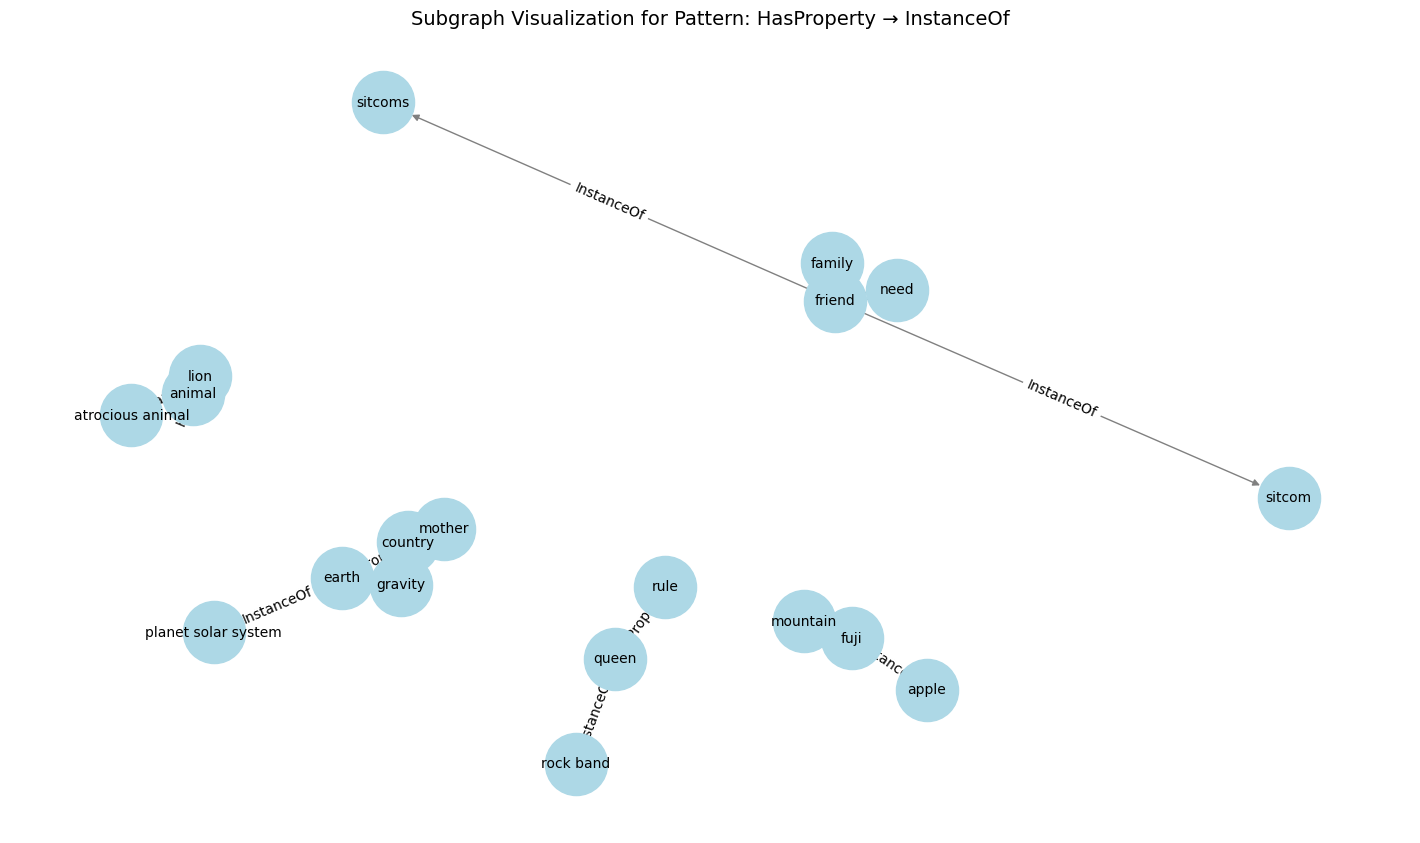

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'HasProperty ‚Üí InstanceOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='HasProperty')
    G_sub.add_edge(b, c, relation='InstanceOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: HasProperty ‚Üí InstanceOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'HasProperty ‚Üí InstanceOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} HasProperty {b}",
            "premise_2": f"{b} InstanceOf {c}",
            "inferred": f"{a} InstanceOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 30 rule candidates for pattern: HasProperty ‚Üí InstanceOf


‚ÄúHere, I visualize a reasoning chain mined from ConceptNet where two-hop paths like ‚Äòman IsA mammal‚Äô and ‚Äòmammal CapableOf breathe air‚Äô allow us to infer that ‚Äòman CapableOf breathe air‚Äô. These patterns are fundamental to commonsense reasoning.‚Äù

**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_HasProperty_InstanceOf.csv", index=False)

print("Saved rule candidates to rule_candidates_HasProperty_InstanceOf.csv")


Saved rule candidates to rule_candidates_HasProperty_InstanceOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration with Google Drive Save

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import drive, userdata
import time
import os

# 1. Mount Google Drive
# drive.mount('/content/drive')

# 2. Define save path inside your Drive folder
drive_folder = "/content/drive/MyDrive/gemini_outputs"
os.makedirs(drive_folder, exist_ok=True)
save_path = os.path.join(drive_folder, "gemini_evaluated_rules.csv")

# 3. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

# 4. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_HasProperty_InstanceOf.csv").to_dict(orient="records")

# 5. If previous results exist, load them
if os.path.exists(save_path):
    previous_results = pd.read_csv(save_path)
    processed = set(previous_results["Inferred"])
    print(f"üìÇ Loaded {len(previous_results)} previous entries.")
else:
    previous_results = pd.DataFrame()
    processed = set()
    print("üîÑ No previous results found. Starting fresh.")

# 6. Evaluate rules
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    if rule["inferred"] in processed:
        continue  # skip already processed

    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            yes_count += 1
            decision = "yes"
        elif answer_text.startswith("no"):
            no_count += 1
            decision = "no"
        else:
            decision = "unclear"

        llm_evals.append({
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(5)

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 7. Save combined results
new_df = pd.DataFrame(llm_evals)
final_df = pd.concat([previous_results, new_df], ignore_index=True)
final_df.to_csv(save_path, index=False)

# 8. Print Summary
print("\nüìä Gemini Validation Stats:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total New Confirmed: {yes_count + no_count}")
print(f"üíæ Saved full file to: {save_path}")


üîÑ No previous results found. Starting fresh.
‚úÖ [1/30] Response: no
‚úÖ [2/30] Response: no
‚úÖ [3/30] Response: no
‚úÖ [4/30] Response: no
‚úÖ [5/30] Response: no
‚úÖ [6/30] Response: no
‚úÖ [7/30] Response: no
‚úÖ [8/30] Response: no
‚úÖ [9/30] Response: no
‚úÖ [10/30] Response: no
‚úÖ [11/30] Response: no
‚úÖ [12/30] Response: no
‚úÖ [13/30] Response: no
‚úÖ [14/30] Response: no
‚úÖ [15/30] Response: no
‚úÖ [16/30] Response: no
‚úÖ [17/30] Response: no
‚úÖ [18/30] Response: no
‚úÖ [19/30] Response: no
‚úÖ [20/30] Response: no
‚úÖ [21/30] Response: no
‚úÖ [22/30] Response: no
‚úÖ [23/30] Response: no
‚úÖ [24/30] Response: no
‚úÖ [25/30] Response: no
‚úÖ [26/30] Response: no
‚úÖ [27/30] Response: no
‚úÖ [28/30] Response: no
‚úÖ [29/30] Response: yes
‚úÖ [30/30] Response: yes

üìä Gemini Validation Stats:
‚úîÔ∏è YES: 2
‚ùå NO : 28
üî¢ Total New Confirmed: 30
üíæ Saved full file to: /content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv


**Visualize Gemini Response**

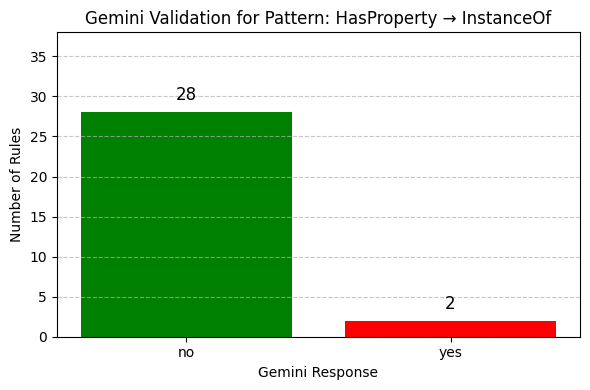

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Count occurrences of each Gemini response
counts = df["Gemini Response"].value_counts()

# Create a bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation for Pattern: HasProperty ‚Üí InstanceOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Saved first 2 'yes' rules to /content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv


**Pattern: HasPainCharacter ‚Üí CapableOf ‚Äî 50 matches**

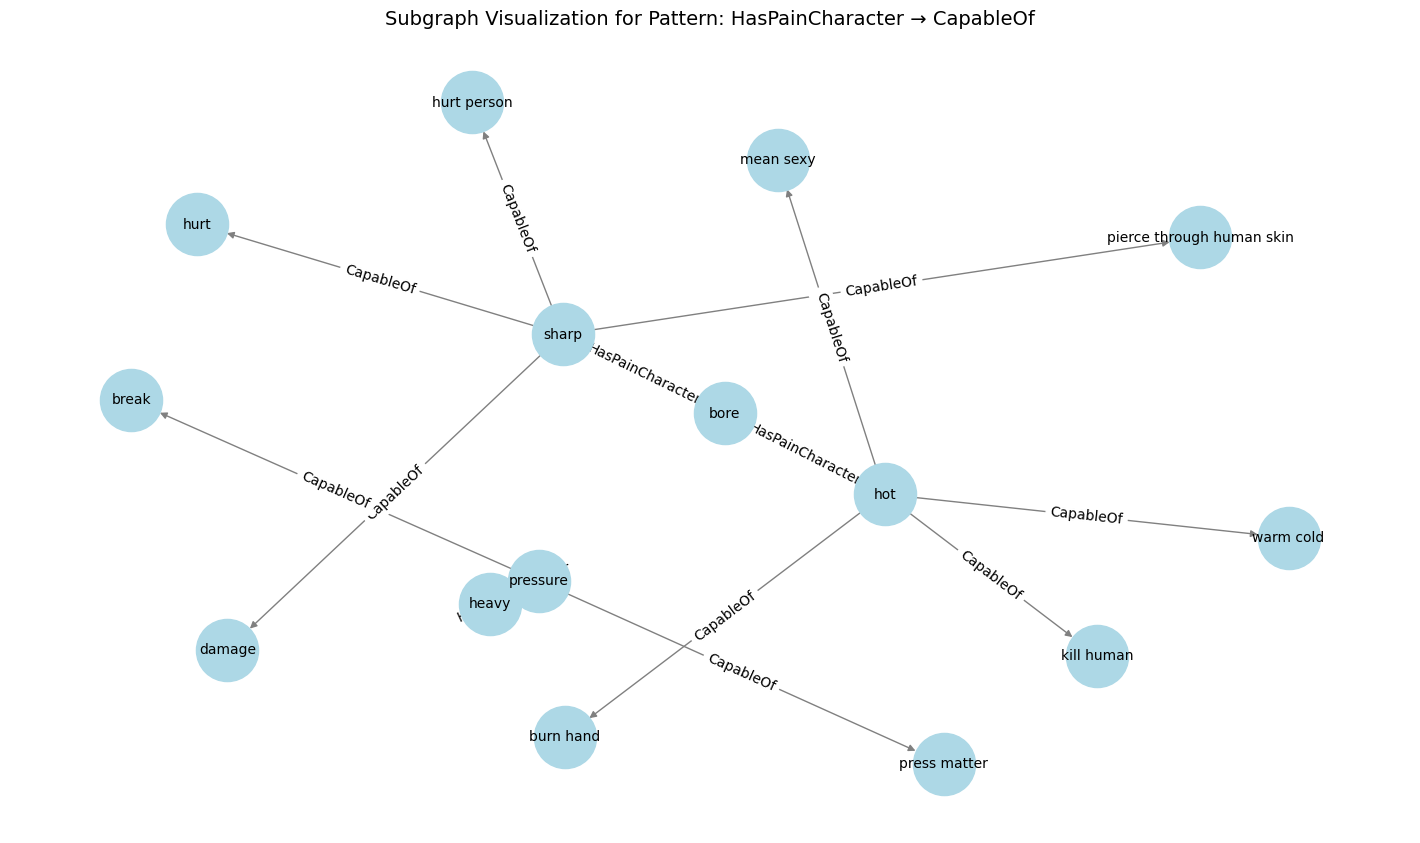

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'HasPainCharacter ‚Üí CapableOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='HasPainCharacter')
    G_sub.add_edge(b, c, relation='CapableOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: HasPainCharacter ‚Üí CapableOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'HasPainCharacter ‚Üí CapableOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} HasPainCharacter {b}",
            "premise_2": f"{b} CapableOf {c}",
            "inferred": f"{a} CapableOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 50 rule candidates for pattern: HasPainCharacter ‚Üí CapableOf


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_HasPainCharacter_CapableOf.csv", index=False)

print("Saved rule candidates to rule_candidates_HasPainCharacter_CapableOf.csv")


Saved rule candidates to rule_candidates_HasPainCharacter_CapableOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "HasPainCharacter ‚Üí CapableOf"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_HasPainCharacter_CapableOf.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/50] Response: yes
‚úÖ [2/50] Response: yes
‚úÖ [3/50] Response: yes
‚úÖ [4/50] Response: yes
‚úÖ [5/50] Response: yes
‚úÖ [6/50] Response: yes
‚úÖ [7/50] Response: yes
‚úÖ [8/50] Response: yes
‚úÖ [9/50] Response: yes
‚úÖ [10/50] Response: yes
‚úÖ [11/50] Response: yes
‚úÖ [12/50] Response: yes
‚úÖ [13/50] Response: yes
‚úÖ [14/50] Response: yes
‚úÖ [15/50] Response: yes
‚úÖ [16/50] Response: yes
‚úÖ [17/50] Response: yes
‚úÖ [18/50] Response: no
‚úÖ [19/50] Response: yes
‚úÖ [20/50] Response: yes
‚úÖ [21/50] Response: yes
‚úÖ [22/50] Response: yes
‚úÖ [23/50] Response: yes
‚úÖ [24/50] Response: yes
‚úÖ [25/50] Response: yes
‚úÖ [26/50] Response: yes
‚úÖ [27/50] Response: yes
‚úÖ [28/50] Response: yes
‚úÖ [29/50] Response: no
‚úÖ [30/50] Response: no
‚úÖ [31/50] Response: no
‚úÖ [32/50] Response: no
‚úÖ [33/50] Response: yes
‚úÖ [34/50] Response: yes
‚úÖ [35/50] Response: yes
‚úÖ [36/50] Response: yes
‚úÖ [37/50] Response: yes
‚úÖ [38/50] Response: yes
‚úÖ [39/50] Response: yes


**Visualize Gemini Response**

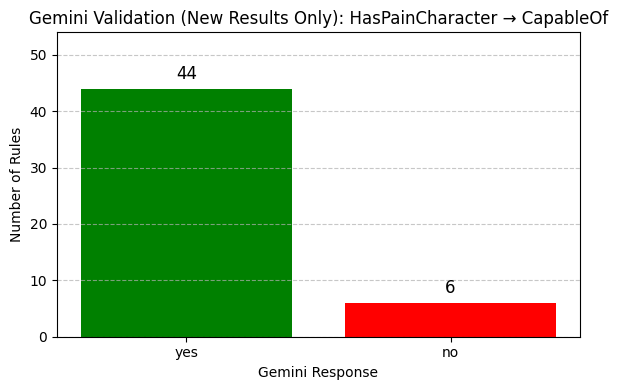

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): HasPainCharacter ‚Üí CapableOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 46 new 'yes' rules. Total now: 46


**Pattern: CreatedBy ‚Üí InheritsFrom ‚Äî 102 matches**

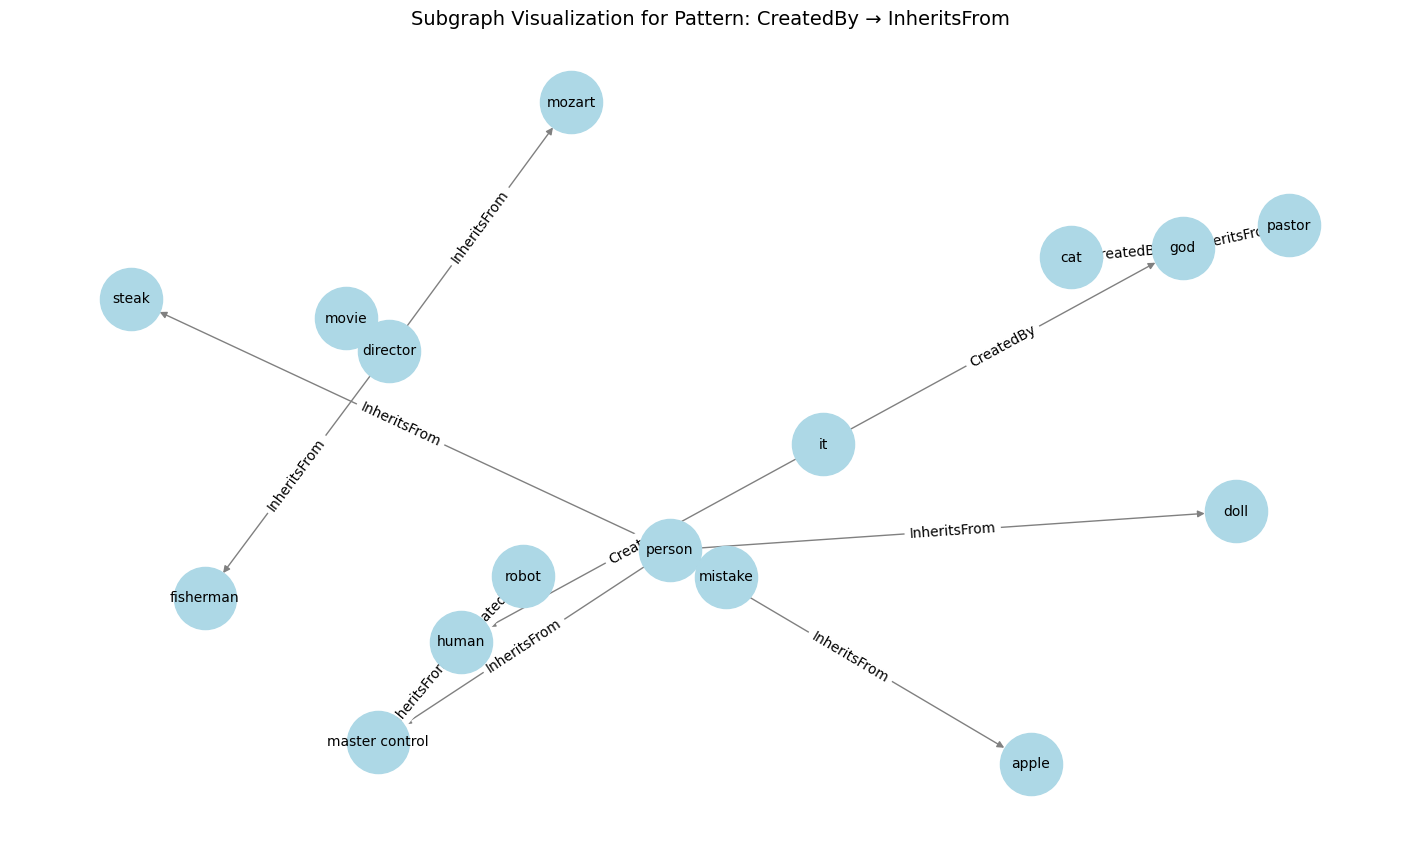

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'CreatedBy ‚Üí InheritsFrom'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='CreatedBy')
    G_sub.add_edge(b, c, relation='InheritsFrom')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: CreatedBy ‚Üí InheritsFrom

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'CreatedBy ‚Üí InheritsFrom'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} CreatedBy {b}",
            "premise_2": f"{b} InheritsFrom {c}",
            "inferred": f"{a} InheritsFrom {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 102 rule candidates for pattern: CreatedBy ‚Üí InheritsFrom


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_CreatedBy_InheritsFrom.csv", index=False)

print("Saved rule candidates to rule_candidates_CreatedBy_InheritsFrom.csv")


Saved rule candidates to rule_candidates_CreatedBy_InheritsFrom.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "CreatedBy ‚Üí InheritsFrom"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_CreatedBy_InheritsFrom.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/102] Response: yes
‚úÖ [2/102] Response: yes
‚úÖ [3/102] Response: no
‚úÖ [4/102] Response: no
‚úÖ [5/102] Response: no
‚úÖ [6/102] Response: yes
‚úÖ [7/102] Response: no
‚úÖ [8/102] Response: no
‚úÖ [9/102] Response: no
‚úÖ [10/102] Response: no
‚úÖ [11/102] Response: no
‚úÖ [12/102] Response: no
‚úÖ [13/102] Response: yes
‚úÖ [14/102] Response: no
‚úÖ [15/102] Response: no
‚úÖ [16/102] Response: yes
‚úÖ [17/102] Response: no
‚úÖ [18/102] Response: no
‚úÖ [19/102] Response: no
‚úÖ [20/102] Response: no
‚úÖ [21/102] Response: yes
‚úÖ [22/102] Response: no
‚úÖ [23/102] Response: no
‚úÖ [24/102] Response: no
‚úÖ [25/102] Response: no
‚úÖ [26/102] Response: no
‚úÖ [27/102] Response: no
‚úÖ [28/102] Response: no
‚úÖ [29/102] Response: no
‚úÖ [30/102] Response: no
‚úÖ [31/102] Response: no
‚úÖ [32/102] Response: no
‚úÖ [33/102] Response: yes
‚úÖ [34/102] Response: no
‚úÖ [35/102] Response: no
‚úÖ [36/102] Response: no
‚úÖ [37/102] Response: no
‚úÖ [38/102] Response: no
‚úÖ [39/102] R

**Visualize Gemini Response**

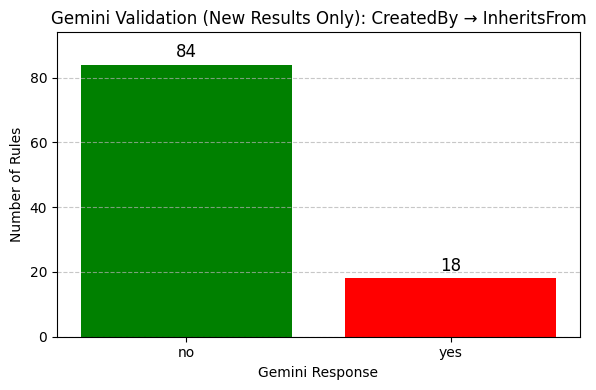

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): CreatedBy ‚Üí InheritsFrom")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 64 new 'yes' rules. Total now: 64


**Pattern: DefinedAs ‚Üí MadeOf ‚Äî 170 matches**

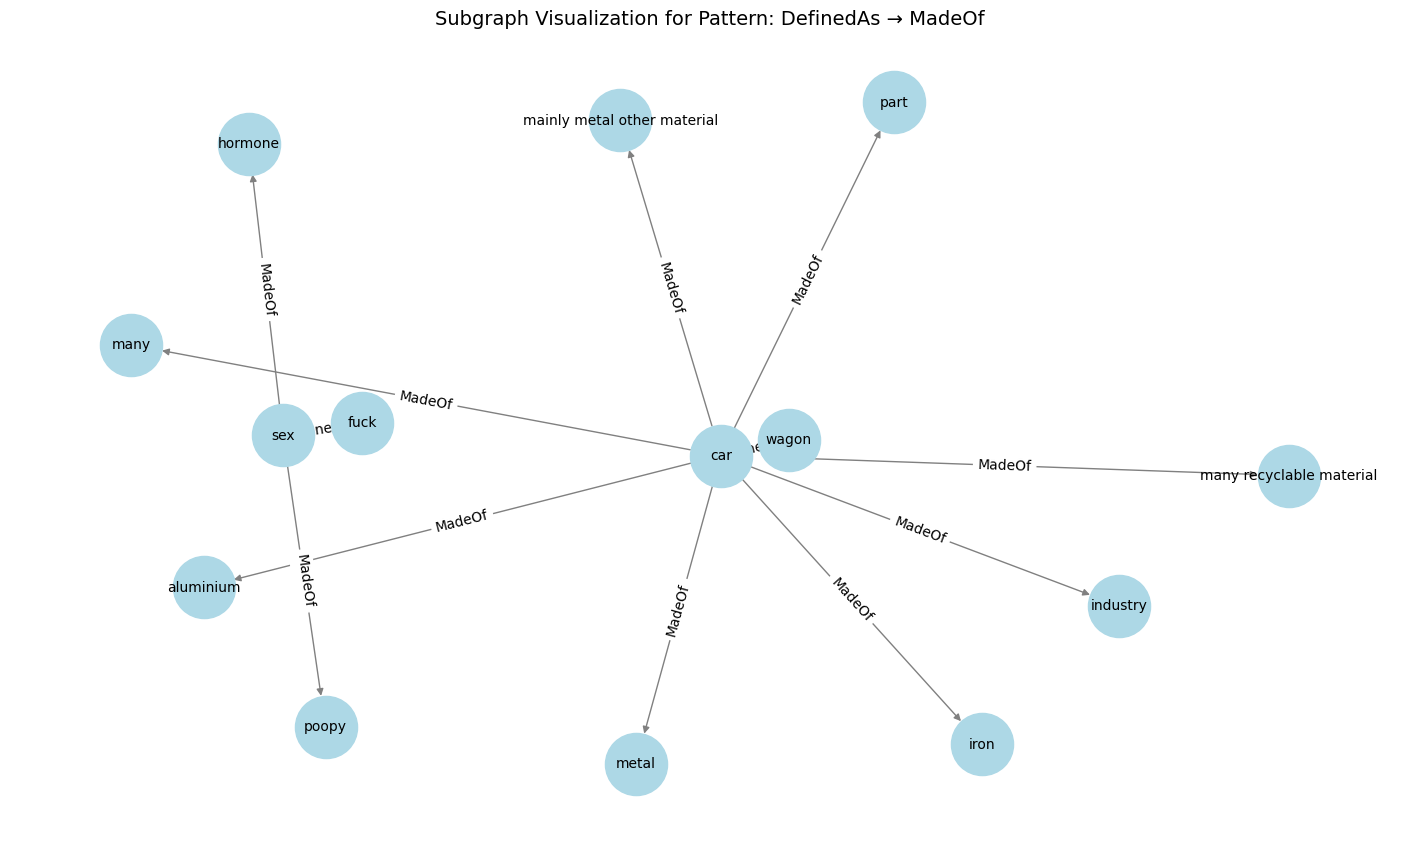

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'DefinedAs ‚Üí MadeOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='DefinedAs')
    G_sub.add_edge(b, c, relation='MadeOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: DefinedAs ‚Üí MadeOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'DefinedAs ‚Üí MadeOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} DefinedAs {b}",
            "premise_2": f"{b} MadeOf {c}",
            "inferred": f"{a} MadeOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 170 rule candidates for pattern: DefinedAs ‚Üí MadeOf


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_DefinedAs_MadeOf.csv", index=False)

print("Saved rule candidates to rule_candidates_DefinedAs_MadeOf.csv")


Saved rule candidates to rule_candidates_DefinedAs_MadeOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "DefinedAs ‚Üí MadeOf"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_DefinedAs_MadeOf.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/170] Response: yes
‚úÖ [2/170] Response: yes
‚úÖ [3/170] Response: yes
‚úÖ [4/170] Response: yes
‚úÖ [5/170] Response: yes
‚úÖ [6/170] Response: yes
‚úÖ [7/170] Response: yes
‚úÖ [8/170] Response: yes
‚úÖ [9/170] Response: yes
‚úÖ [10/170] Response: yes
‚úÖ [11/170] Response: yes
‚úÖ [12/170] Response: yes
‚úÖ [13/170] Response: yes
‚úÖ [14/170] Response: yes
‚úÖ [15/170] Response: yes
‚úÖ [16/170] Response: yes
‚úÖ [17/170] Response: yes
‚úÖ [18/170] Response: yes
‚úÖ [19/170] Response: yes
‚úÖ [20/170] Response: yes
‚úÖ [21/170] Response: yes
‚úÖ [22/170] Response: yes
‚úÖ [23/170] Response: yes
‚úÖ [24/170] Response: yes
‚úÖ [25/170] Response: yes
‚úÖ [26/170] Response: no
‚úÖ [27/170] Response: no
‚úÖ [28/170] Response: no
‚úÖ [29/170] Response: yes
‚úÖ [30/170] Response: yes
‚úÖ [31/170] Response: yes
‚úÖ [32/170] Response: yes
‚úÖ [33/170] Response: yes
‚úÖ [34/170] Response: yes
‚úÖ [35/170] Response: no
‚úÖ [36/170] Response: yes
‚úÖ [37/170] Response: yes
‚úÖ [38/170] R

**Visualize Gemini Response**

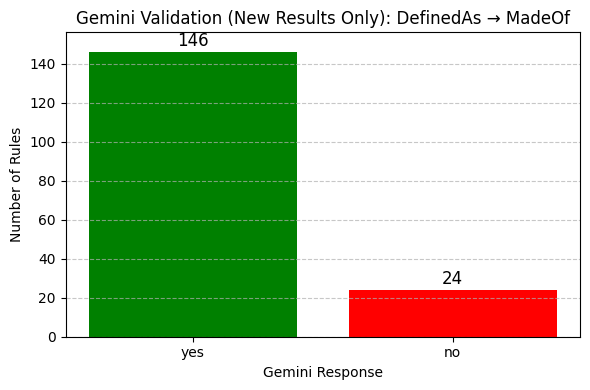

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): DefinedAs ‚Üí MadeOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 210 new 'yes' rules. Total now: 210


**Pattern: InstanceOf ‚Üí AtLocation ‚Äî 530 matches**

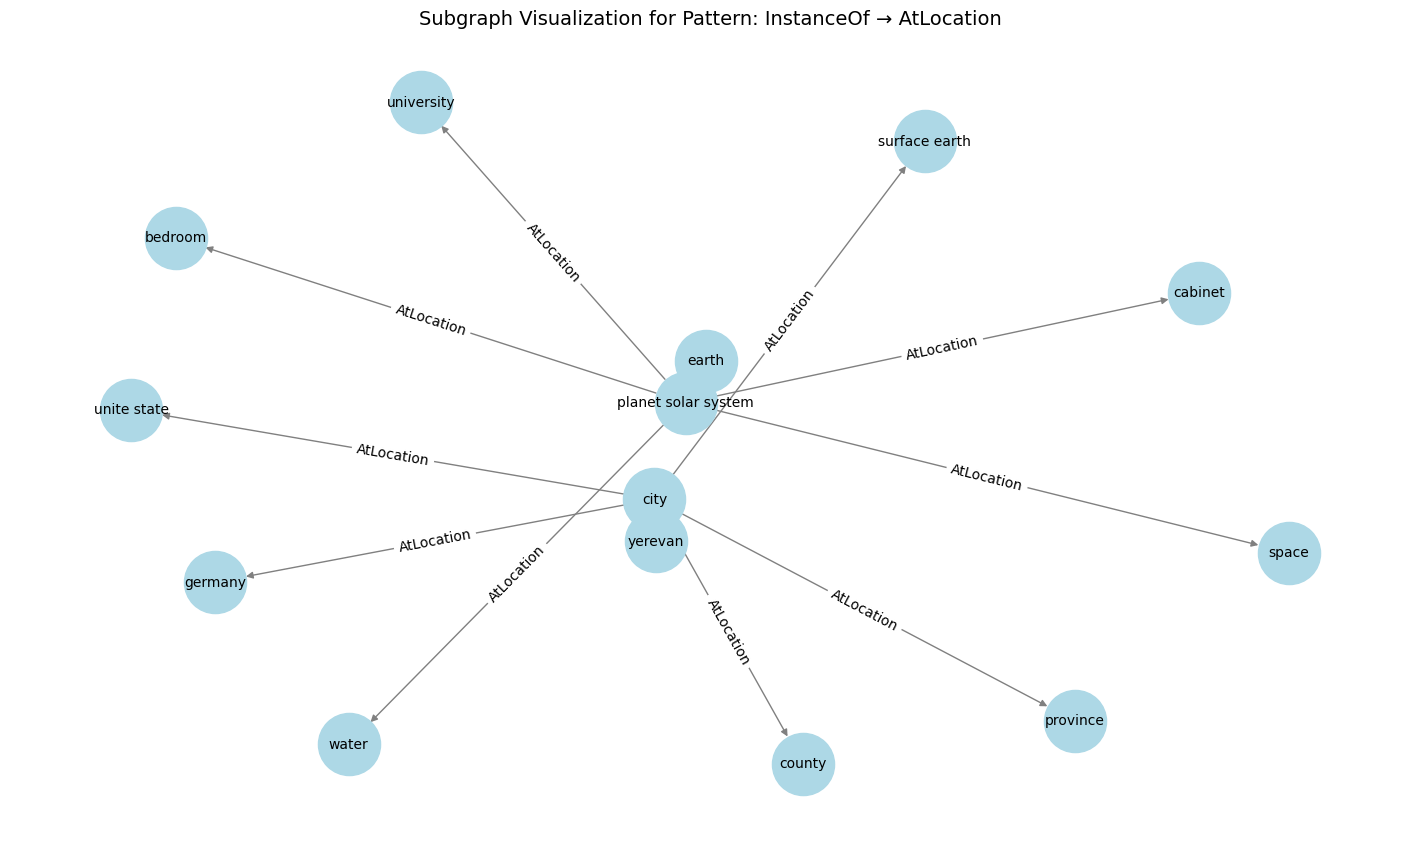

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'InstanceOf ‚Üí AtLocation'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='InstanceOf')
    G_sub.add_edge(b, c, relation='AtLocation')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: InstanceOf ‚Üí AtLocation

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'InstanceOf ‚Üí AtLocation'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} InstanceOf {b}",
            "premise_2": f"{b} AtLocation {c}",
            "inferred": f"{a} AtLocation {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 530 rule candidates for pattern: InstanceOf ‚Üí AtLocation


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_InstanceOf_AtLocation.csv", index=False)

print("Saved rule candidates to rule_candidates_InstanceOf_AtLocation.csv")


Saved rule candidates to rule_candidates_InstanceOf_AtLocation.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "InstanceOf_AtLocation"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_InstanceOf_AtLocation.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/530] Response: no
‚úÖ [2/530] Response: no
‚úÖ [3/530] Response: no
‚úÖ [4/530] Response: no
‚úÖ [5/530] Response: yes
‚úÖ [6/530] Response: no
‚úÖ [7/530] Response: yes
‚úÖ [8/530] Response: no
‚úÖ [9/530] Response: yes
‚úÖ [10/530] Response: no
‚úÖ [11/530] Response: no
‚úÖ [12/530] Response: no
‚úÖ [13/530] Response: no
‚úÖ [14/530] Response: no
‚úÖ [15/530] Response: no
‚úÖ [16/530] Response: no
‚úÖ [17/530] Response: yes
‚úÖ [18/530] Response: yes
‚úÖ [19/530] Response: no
‚úÖ [20/530] Response: no
‚úÖ [21/530] Response: no
‚úÖ [22/530] Response: no
‚úÖ [23/530] Response: no
‚úÖ [24/530] Response: no
‚úÖ [25/530] Response: no
‚úÖ [26/530] Response: yes
‚úÖ [27/530] Response: no
‚úÖ [28/530] Response: yes
‚úÖ [29/530] Response: yes
‚úÖ [30/530] Response: yes
‚úÖ [31/530] Response: yes
‚úÖ [32/530] Response: yes
‚úÖ [33/530] Response: no
‚úÖ [34/530] Response: no
‚úÖ [35/530] Response: no
‚úÖ [36/530] Response: yes
‚úÖ [37/530] Response: no
‚úÖ [38/530] Response: yes
‚úÖ [39/

**Visualize Gemini Response**

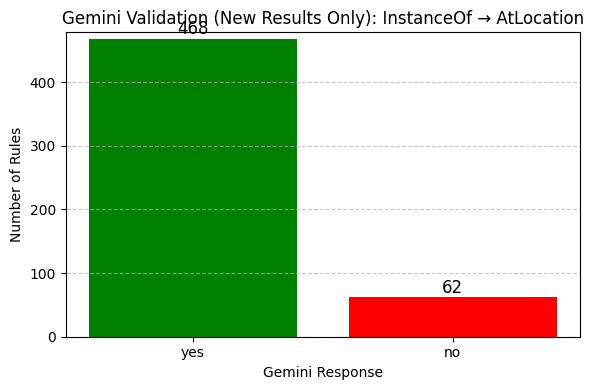

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): InstanceOf ‚Üí AtLocation")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 678 new 'yes' rules. Total now: 678


**Pattern: PartOf ‚Üí HasSubevent ‚Äî 1607 matches**

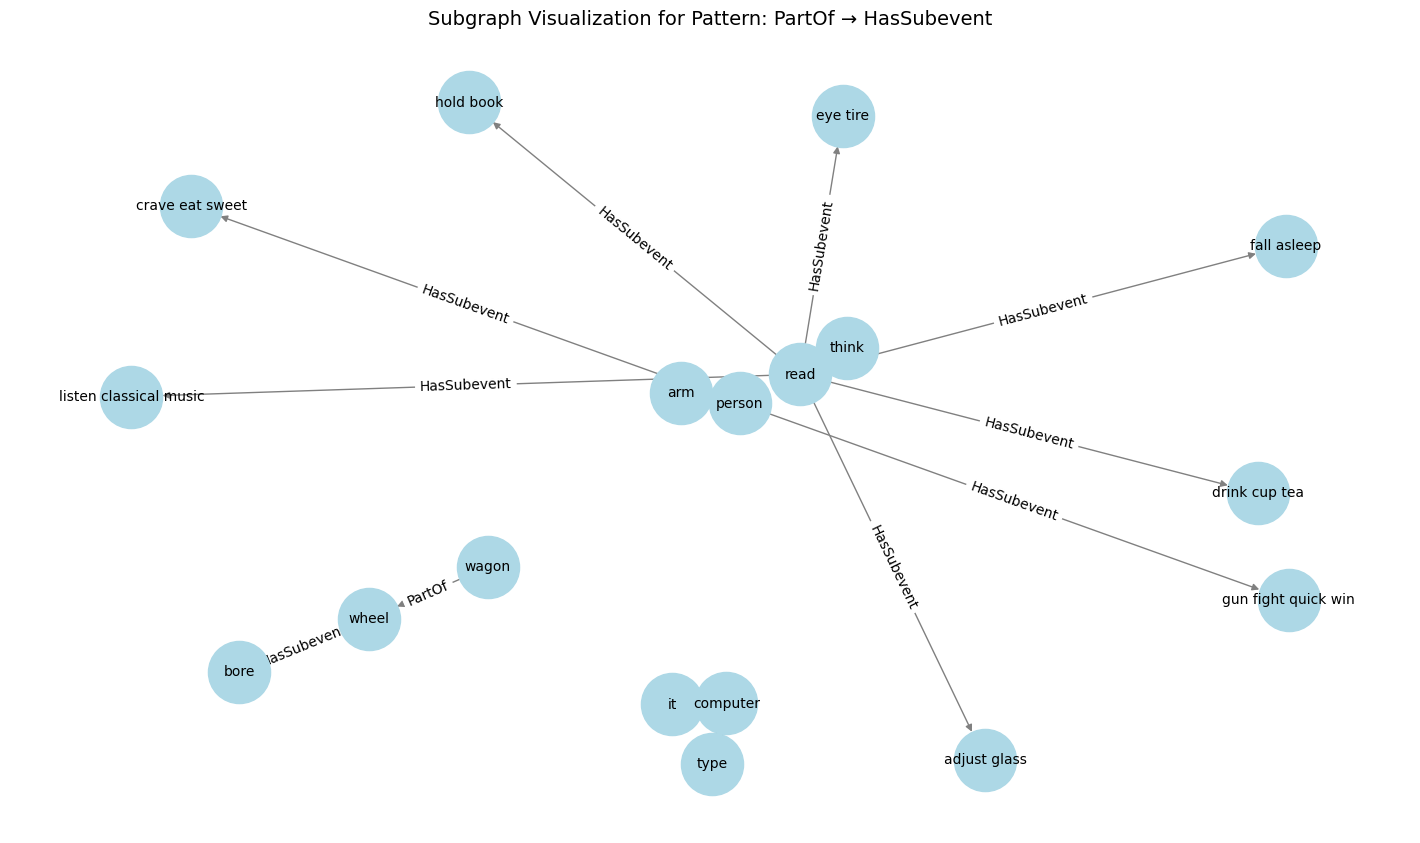

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'PartOf ‚Üí HasSubevent'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='PartOf')
    G_sub.add_edge(b, c, relation='HasSubevent')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: PartOf ‚Üí HasSubevent

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'PartOf ‚Üí HasSubevent'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} PartOf {b}",
            "premise_2": f"{b} HasSubevent {c}",
            "inferred": f"{a} HasSubevent {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 1607 rule candidates for pattern: PartOf ‚Üí HasSubevent


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_PartOf_HasSubevent.csv", index=False)

print("Saved rule candidates to rule_candidates_PartOf_HasSubevent.csv")


Saved rule candidates to rule_candidates_PartOf_HasSubevent.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "PartOf_HasSubevent"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_PartOf_HasSubevent.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/1607] Response: no
‚úÖ [2/1607] Response: no
‚úÖ [3/1607] Response: no
‚úÖ [4/1607] Response: yes
‚úÖ [5/1607] Response: no
‚úÖ [6/1607] Response: no
‚úÖ [7/1607] Response: no
‚úÖ [8/1607] Response: no
‚úÖ [9/1607] Response: no
‚úÖ [10/1607] Response: no
‚úÖ [11/1607] Response: no
‚úÖ [12/1607] Response: no
‚úÖ [13/1607] Response: no
‚úÖ [14/1607] Response: no
‚úÖ [15/1607] Response: yes
‚úÖ [16/1607] Response: no
‚úÖ [17/1607] Response: no
‚úÖ [18/1607] Response: yes
‚úÖ [19/1607] Response: yes
‚úÖ [20/1607] Response: no
‚úÖ [21/1607] Response: yes
‚úÖ [22/1607] Response: yes
‚úÖ [23/1607] Response: no
‚úÖ [24/1607] Response: no
‚úÖ [25/1607] Response: no
‚úÖ [26/1607] Response: no
‚úÖ [27/1607] Response: no
‚úÖ [28/1607] Response: no
‚úÖ [29/1607] Response: no
‚úÖ [30/1607] Response: no
‚úÖ [31/1607] Response: no
‚úÖ [32/1607] Response: no
‚úÖ [33/1607] Response: no
‚úÖ [34/1607] Response: no
‚úÖ [35/1607] Response: no
‚úÖ [36/1607] Response: no
‚úÖ [37/1607] Response: no
‚úÖ 

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 229.11ms


‚úÖ [347/1607] Response: no
‚úÖ [348/1607] Response: no
‚úÖ [349/1607] Response: no
‚úÖ [350/1607] Response: no
‚úÖ [351/1607] Response: no
‚úÖ [352/1607] Response: no
‚úÖ [353/1607] Response: no
‚úÖ [354/1607] Response: no
‚úÖ [355/1607] Response: no
‚úÖ [356/1607] Response: no
‚úÖ [357/1607] Response: no
‚úÖ [358/1607] Response: no
‚úÖ [359/1607] Response: no
‚úÖ [360/1607] Response: no
‚úÖ [361/1607] Response: no
‚úÖ [362/1607] Response: no
‚úÖ [363/1607] Response: no
‚úÖ [364/1607] Response: no
‚úÖ [365/1607] Response: no
‚úÖ [366/1607] Response: no
‚úÖ [367/1607] Response: no
‚úÖ [368/1607] Response: no
‚úÖ [369/1607] Response: no
‚úÖ [370/1607] Response: no
‚úÖ [371/1607] Response: no
‚úÖ [372/1607] Response: no
‚úÖ [373/1607] Response: no
‚úÖ [374/1607] Response: no
‚úÖ [375/1607] Response: no
‚úÖ [376/1607] Response: no
‚úÖ [377/1607] Response: no
‚úÖ [378/1607] Response: no
‚úÖ [379/1607] Response: no
‚úÖ [380/1607] Response: no
‚úÖ [381/1607] Response: no
‚úÖ [382/1607] Respo

**Visualize Gemini Response**

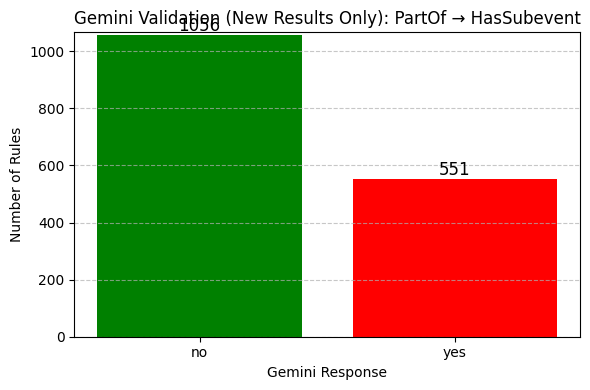

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): PartOf ‚Üí HasSubevent")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 1229 new 'yes' rules. Total now: 1229


**Pattern: LocatedNear ‚Üí Causes ‚Äî 3084 matches**

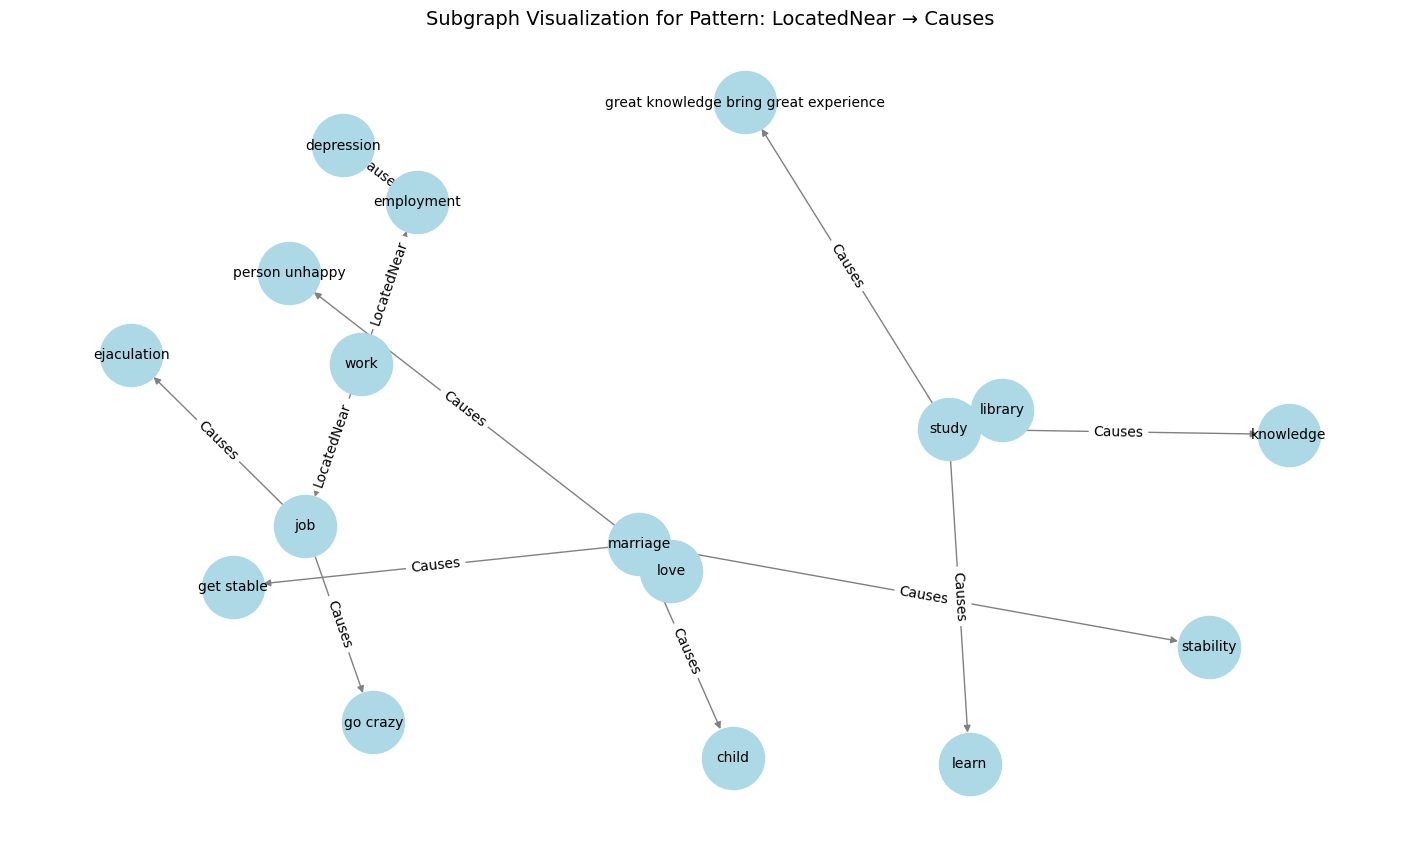

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'LocatedNear ‚Üí Causes'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='LocatedNear')
    G_sub.add_edge(b, c, relation='Causes')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: LocatedNear ‚Üí Causes

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'LocatedNear ‚Üí Causes'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} LocatedNear {b}",
            "premise_2": f"{b} Causes {c}",
            "inferred": f"{a} Causes {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 3084 rule candidates for pattern: LocatedNear ‚Üí Causes


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_LocatedNear_Causes.csv", index=False)

print("Saved rule candidates to rule_candidates_LocatedNear_Causes.csv")


Saved rule candidates to rule_candidates_LocatedNear_Causes.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "LocatedNear_Causes"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_LocatedNear_Causes.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ‚è≤Ô∏è Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Total Evaluated: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


‚úÖ [1/3084] Response: yes
‚úÖ [2/3084] Response: no
‚úÖ [3/3084] Response: yes
‚úÖ [4/3084] Response: no
‚úÖ [5/3084] Response: no
‚úÖ [6/3084] Response: no
‚úÖ [7/3084] Response: no
‚úÖ [8/3084] Response: no
‚úÖ [9/3084] Response: no
‚úÖ [10/3084] Response: no
‚úÖ [11/3084] Response: no
‚úÖ [12/3084] Response: no
‚úÖ [13/3084] Response: no
‚úÖ [14/3084] Response: no
‚úÖ [15/3084] Response: no
‚úÖ [16/3084] Response: no
‚úÖ [17/3084] Response: no
‚úÖ [18/3084] Response: no
‚úÖ [19/3084] Response: no
‚úÖ [20/3084] Response: no
‚úÖ [21/3084] Response: no
‚úÖ [22/3084] Response: no
‚úÖ [23/3084] Response: no
‚úÖ [24/3084] Response: yes
‚úÖ [25/3084] Response: no
‚úÖ [26/3084] Response: no
‚úÖ [27/3084] Response: no
‚úÖ [28/3084] Response: no
‚úÖ [29/3084] Response: no
‚úÖ [30/3084] Response: no
‚úÖ [31/3084] Response: no
‚úÖ [32/3084] Response: no
‚úÖ [33/3084] Response: no
‚úÖ [34/3084] Response: no
‚úÖ [35/3084] Response: no
‚úÖ [36/3084] Response: no
‚úÖ [37/3084] Response: no
‚úÖ [38

**Visualize Gemini Response**

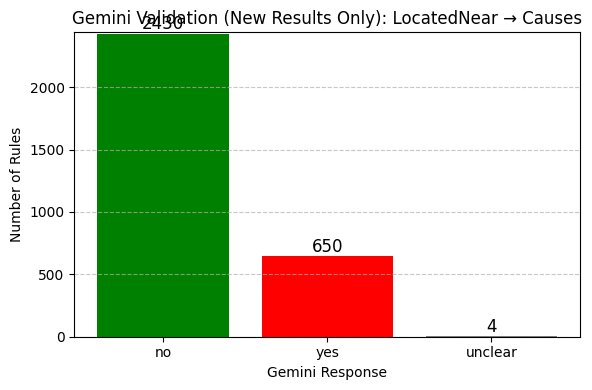

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): LocatedNear ‚Üí Causes")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Appended 1879 new 'yes' rules. Total now: 1879


**Pattern: InheritsFrom ‚Üí AtLocation ‚Äî 10114 matches**

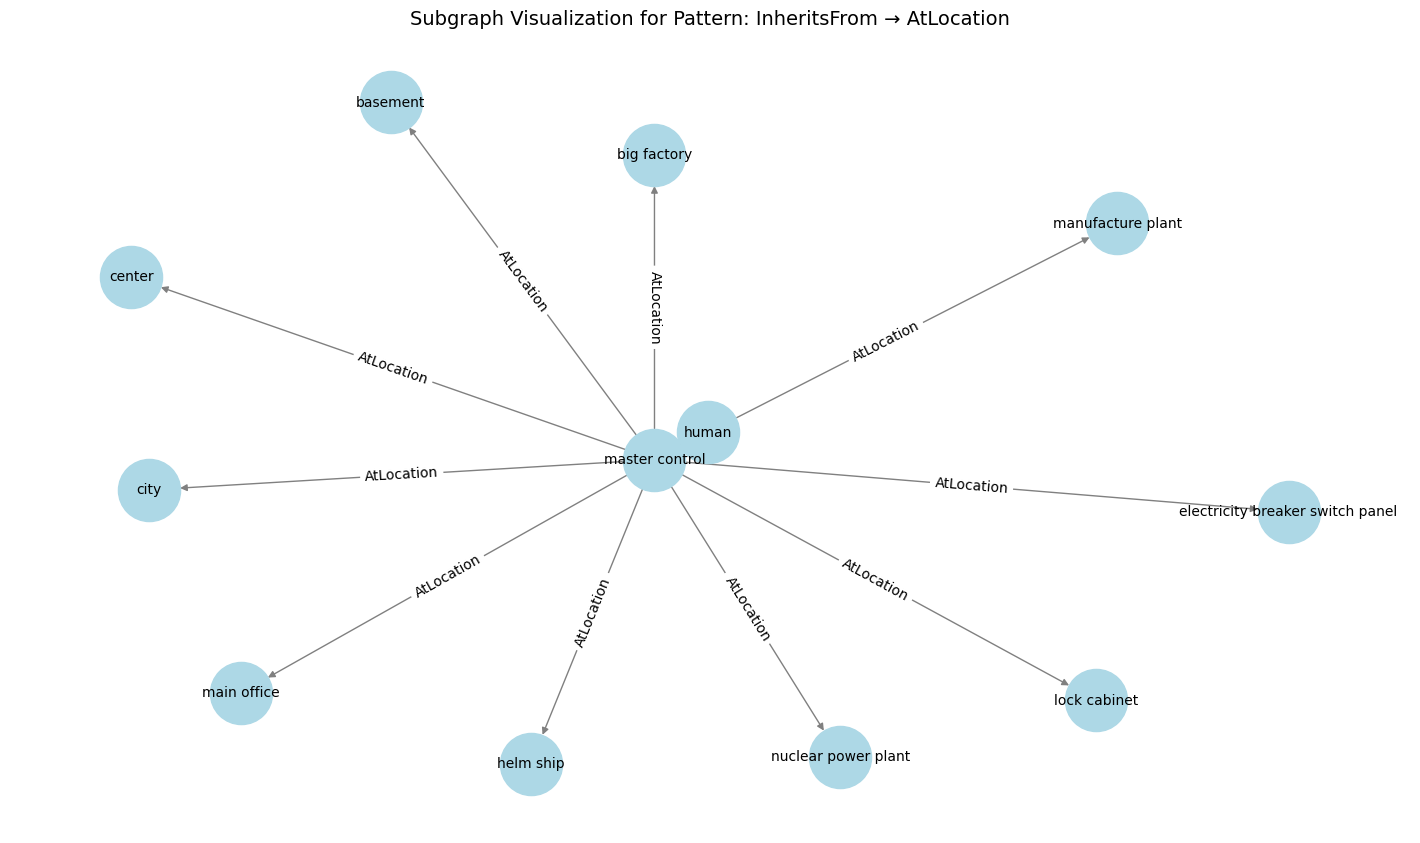

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'InheritsFrom ‚Üí AtLocation'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='InheritsFrom')
    G_sub.add_edge(b, c, relation='AtLocation')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: InheritsFrom ‚Üí AtLocation

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'InheritsFrom ‚Üí AtLocation'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} InheritsFrom {b}",
            "premise_2": f"{b} AtLocation {c}",
            "inferred": f"{a} AtLocation {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"‚úÖ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"‚ùå Pattern '{target_pattern}' not found in two_hop_patterns.")


‚úÖ Created 10114 rule candidates for pattern: InheritsFrom ‚Üí AtLocation


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_InheritsFrom_AtLocation.csv", index=False)

print("Saved rule candidates to rule_candidates_InheritsFrom_AtLocation.csv")


Saved rule candidates to rule_candidates_InheritsFrom_AtLocation.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation (Resumable + Stats)

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import drive, userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name
pattern_name = "InheritsFrom_AtLocation"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_InheritsFrom_AtLocation.csv").to_dict(orient="records")

# 4. Load previously evaluated results
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"
evaluated_inferred = set()

if os.path.exists(results_file):
    existing_df = pd.read_csv(results_file)
    evaluated_inferred = set(existing_df["Inferred"].tolist())  # Use Inferred to avoid rechecking
    print(f"üîÅ Loaded {len(evaluated_inferred)} previously evaluated rules")

# 5. Initialize Gemini
model = genai.GenerativeModel("gemini-2.0-flash")

# 6. Run LLM evaluation
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    #if rule["inferred"] in evaluated_inferred:
        #continue  # Skip already evaluated rules

    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"‚úÖ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)

    except Exception as e:
        print(f"‚ùå Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 7. Append or create CSV file
results_df = pd.DataFrame(llm_evals)

if os.path.exists(results_file):
    combined_df = pd.concat([existing_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(subset=["Inferred"], inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"üìÅ Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"üìÅ Created new file: {results_file} with {len(results_df)} rows")

# 8. Stats
print("\nüìä Gemini Validation Summary:")
print(f"‚úîÔ∏è YES: {yes_count}")
print(f"‚ùå NO : {no_count}")
print(f"üî¢ Newly Evaluated This Run: {yes_count + no_count}")
print(f"üìÅ Saved to {results_file}")


Streaming output truncated to the last 5000 lines.
‚úÖ [5122/10114] Response: yes
‚úÖ [5123/10114] Response: yes
‚úÖ [5124/10114] Response: yes
‚úÖ [5125/10114] Response: yes
‚úÖ [5126/10114] Response: yes
‚úÖ [5127/10114] Response: yes
‚úÖ [5128/10114] Response: yes
‚úÖ [5129/10114] Response: yes
‚úÖ [5130/10114] Response: yes
‚úÖ [5131/10114] Response: yes
‚úÖ [5132/10114] Response: yes
‚úÖ [5133/10114] Response: yes
‚úÖ [5134/10114] Response: yes
‚úÖ [5135/10114] Response: yes
‚úÖ [5136/10114] Response: yes
‚úÖ [5137/10114] Response: yes
‚úÖ [5138/10114] Response: no
‚úÖ [5139/10114] Response: yes
‚úÖ [5140/10114] Response: yes
‚úÖ [5141/10114] Response: yes
‚úÖ [5142/10114] Response: no
‚úÖ [5143/10114] Response: yes
‚úÖ [5144/10114] Response: yes
‚úÖ [5145/10114] Response: yes
‚úÖ [5146/10114] Response: no
‚úÖ [5147/10114] Response: yes
‚úÖ [5148/10114] Response: yes
‚úÖ [5149/10114] Response: no
‚úÖ [5150/10114] Response: yes
‚úÖ [5151/10114] Response: yes
‚úÖ [5152/10114] Respon

**Visualize Gemini Response**

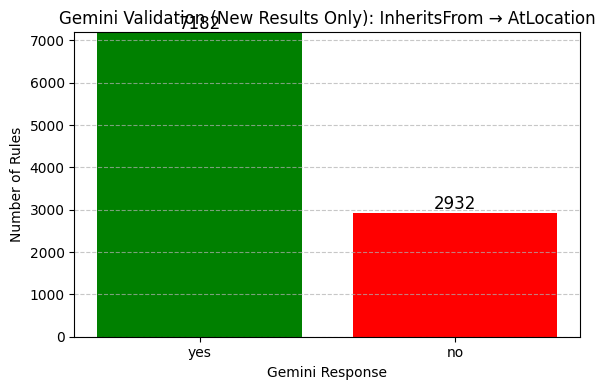

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ‚úÖ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): InheritsFrom ‚Üí AtLocation")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"‚úÖ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"‚úÖ Saved first {len(yes_df)} 'yes' rules to {output_path}")


‚úÖ Saved first 8923 'yes' rules to gemini_confirmed_yes_rules.csv


In [ ]:
import pandas as pd

# Load the CSV file
csv_path = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"
df = pd.read_csv(csv_path)

# Drop duplicates based on the 'Inferred' column
df.drop_duplicates(subset=["Inferred"], inplace=True)

# Save the cleaned DataFrame back to the same file
df.to_csv(csv_path, index=False)

print(f"‚úÖ Cleaned file saved. Total unique rules: {len(df)}")
